# Method 6 - Best Minus Rest Top 3

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 3].copy()                                                                    
short_ideas = valid_data[valid_data['pos_rank'] > 3].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

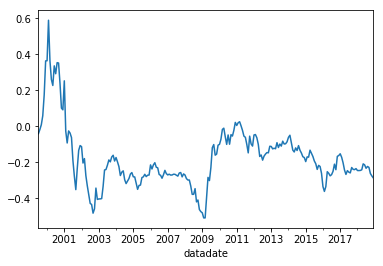

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.363632
2000-12-31   -0.199147
2001-12-31   -0.181660
2002-12-31   -0.334703
2003-12-31    0.358737
2004-12-31   -0.079419
2005-12-31   -0.018362
2006-12-31    0.010616
2007-12-31   -0.002061
2008-12-31   -0.284365
2009-12-31    0.700005
2010-12-31    0.141126
2011-12-31   -0.128533
2012-12-31   -0.001064
2013-12-31    0.027590
2014-12-31   -0.095313
2015-12-31   -0.106252
2016-12-31    0.133806
2017-12-31   -0.086507
2018-12-31   -0.067125
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     123.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.36e-56
Time:                        14:54:51   Log-Likelihood:                 468.09
No. Observations:                 234   AIC:                            -926.2
Df Residuals:                     229   BIC:                            -908.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.814      0.416      -0.003       0.006
mktrf          0.3701      0.062      5.996      0.000       0.248       0.492
me             0.2801      0.072      3.901      0.000       0.139       0.422
ia            -0.2922      0.109     -2.678      0.008      -0.507      -0.077
roe           -0.9913      0.093    -10.614      0.000      -1.175      -0.807
==============================================================================
Omnibus:                       54.807   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.748
Skew:                           0.922   Prob(JB):                     8.48e-43
Kurtosis:                       7.059   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     99.60
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.64e-49
Time:                        14:54:51   Log-Likelihood:                 468.09
No. Observations:                 234   AIC:                            -926.2
Df Residuals:                     229   BIC:                            -908.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.777      0.437      -0.003       0.006
mktrf          0.3701      0.096      3.871      0.000       0.183       0.557
me             0.2801      0.086      3.259      0.001       0.112       0.448
ia            -0.2922      0.171     -1.705      0.088      -0.628       0.044
roe           -0.9913      0.149     -6.654      0.000      -1.283      -0.699
==============================================================================
Omnibus:                       54.807   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.748
Skew:                           0.922   Prob(JB):                     8.48e-43
Kurtosis:                       7.059   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     162.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.45e-65
Time:                        14:54:51   Log-Likelihood:                 468.09
No. Observations:                 234   AIC:                            -926.2
Df Residuals:                     229   BIC:                            -908.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.725      0.469      -0.003       0.007
mktrf          0.3701      0.097      3.806      0.000       0.179       0.561
me             0.2801      0.096      2.903      0.004       0.091       0.469
ia            -0.2922      0.166     -1.760      0.078      -0.618       0.033
roe           -0.9913      0.162     -6.122      0.000      -1.309      -0.674
==============================================================================
Omnibus:                       54.807   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.748
Skew:                           0.922   Prob(JB):                     8.48e-43
Kurtosis:                       7.059   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     89.29
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-51
Time:                        14:54:51   Log-Likelihood:                 460.65
No. Observations:                 234   AIC:                            -909.3
Df Residuals:                     228   BIC:                            -888.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.786      0.433      -0.003       0.007
mktrf          0.4333      0.064      6.773      0.000       0.307       0.559
smb            0.2601      0.084      3.081      0.002       0.094       0.426
hml            0.1082      0.100      1.087      0.278      -0.088       0.304
rmw           -1.0032      0.113     -8.914      0.000      -1.225      -0.781
cma           -0.1981      0.143     -1.385      0.167      -0.480       0.084
==============================================================================
Omnibus:                       98.154   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.157
Skew:                           1.682   Prob(JB):                     1.92e-90
Kurtosis:                       8.573   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     35.79
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.74e-27
Time:                        14:54:51   Log-Likelihood:                 460.65
No. Observations:                 234   AIC:                            -909.3
Df Residuals:                     228   BIC:                            -888.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.749      0.454      -0.003       0.007
mktrf          0.4333      0.067      6.481      0.000       0.302       0.564
smb            0.2601      0.080      3.237      0.001       0.103       0.417
hml            0.1082      0.145      0.744      0.457      -0.177       0.393
rmw           -1.0032      0.149     -6.720      0.000      -1.296      -0.711
cma           -0.1981      0.211     -0.938      0.348      -0.612       0.216
==============================================================================
Omnibus:                       98.154   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.157
Skew:                           1.682   Prob(JB):                     1.92e-90
Kurtosis:                       8.573   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     39.54
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.67e-29
Time:                        14:54:51   Log-Likelihood:                 460.65
No. Observations:                 234   AIC:                            -909.3
Df Residuals:                     228   BIC:                            -888.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.671      0.502      -0.004       0.007
mktrf          0.4333      0.065      6.675      0.000       0.306       0.561
smb            0.2601      0.083      3.143      0.002       0.098       0.422
hml            0.1082      0.109      0.988      0.323      -0.106       0.323
rmw           -1.0032      0.152     -6.619      0.000      -1.300      -0.706
cma           -0.1981      0.189     -1.048      0.295      -0.569       0.172
==============================================================================
Omnibus:                       98.154   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.157
Skew:                           1.682   Prob(JB):                     1.92e-90
Kurtosis:                       8.573   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     103.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.81e-50
Time:                        14:54:51   Log-Likelihood:                 454.20
No. Observations:                 234   AIC:                            -898.4
Df Residuals:                     229   BIC:                            -881.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.708      0.480      -0.006       0.003
mktrf          0.5292      0.060      8.776      0.000       0.410       0.648
smb            0.7274      0.075      9.664      0.000       0.579       0.876
hml           -0.2848      0.075     -3.809      0.000      -0.432      -0.137
umd           -0.3784      0.049     -7.714      0.000      -0.475      -0.282
==============================================================================
Omnibus:                       48.993   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.312
Skew:                           0.945   Prob(JB):                     4.54e-27
Kurtosis:                       5.978   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     58.45
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.08e-34
Time:                        14:54:51   Log-Likelihood:                 454.20
No. Observations:                 234   AIC:                            -898.4
Df Residuals:                     229   BIC:                            -881.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.788      0.431      -0.006       0.002
mktrf          0.5292      0.080      6.599      0.000       0.372       0.686
smb            0.7274      0.080      9.048      0.000       0.570       0.885
hml           -0.2848      0.117     -2.433      0.015      -0.514      -0.055
umd           -0.3784      0.082     -4.620      0.000      -0.539      -0.218
==============================================================================
Omnibus:                       48.993   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.312
Skew:                           0.945   Prob(JB):                     4.54e-27
Kurtosis:                       5.978   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     74.43
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.51e-40
Time:                        14:54:51   Log-Likelihood:                 454.20
No. Observations:                 234   AIC:                            -898.4
Df Residuals:                     229   BIC:                            -881.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.805      0.421      -0.006       0.002
mktrf          0.5292      0.080      6.599      0.000       0.372       0.686
smb            0.7274      0.072     10.046      0.000       0.585       0.869
hml           -0.2848      0.120     -2.375      0.018      -0.520      -0.050
umd           -0.3784      0.084     -4.510      0.000      -0.543      -0.214
==============================================================================
Omnibus:                       48.993   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.312
Skew:                           0.945   Prob(JB):                     4.54e-27
Kurtosis:                       5.978   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     65.75
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.87e-29
Time:                        14:54:51   Log-Likelihood:                 218.07
No. Observations:                 120   AIC:                            -426.1
Df Residuals:                     115   BIC:                            -412.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.004      1.393      0.166      -0.002       0.013
mktrf          0.3437      0.104      3.321      0.001       0.139       0.549
me             0.2167      0.102      2.119      0.036       0.014       0.419
ia            -0.4750      0.160     -2.967      0.004      -0.792      -0.158
roe           -0.9754      0.142     -6.883      0.000      -1.256      -0.695
==============================================================================
Omnibus:                       17.813   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.587
Skew:                           0.679   Prob(JB):                     3.76e-07
Kurtosis:                       5.019   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     62.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.74e-28
Time:                        14:54:51   Log-Likelihood:                 218.07
No. Observations:                 120   AIC:                            -426.1
Df Residuals:                     115   BIC:                            -412.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.004      1.444      0.149      -0.002       0.013
mktrf          0.3437      0.146      2.348      0.019       0.057       0.631
me             0.2167      0.111      1.958      0.050      -0.000       0.434
ia            -0.4750      0.219     -2.164      0.030      -0.905      -0.045
roe           -0.9754      0.210     -4.647      0.000      -1.387      -0.564
==============================================================================
Omnibus:                       17.813   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.587
Skew:                           0.679   Prob(JB):                     3.76e-07
Kurtosis:                       5.019   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     115.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.48e-39
Time:                        14:54:51   Log-Likelihood:                 218.07
No. Observations:                 120   AIC:                            -426.1
Df Residuals:                     115   BIC:                            -412.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.004      1.420      0.156      -0.002       0.013
mktrf          0.3437      0.150      2.297      0.022       0.050       0.637
me             0.2167      0.125      1.734      0.083      -0.028       0.462
ia            -0.4750      0.197     -2.415      0.016      -0.860      -0.090
roe           -0.9754      0.235     -4.157      0.000      -1.435      -0.516
==============================================================================
Omnibus:                       17.813   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.587
Skew:                           0.679   Prob(JB):                     3.76e-07
Kurtosis:                       5.019   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     49.81
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.06e-27
Time:                        14:54:51   Log-Likelihood:                 216.17
No. Observations:                 120   AIC:                            -420.3
Df Residuals:                     114   BIC:                            -403.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.004      1.591      0.114      -0.002       0.014
mktrf          0.4949      0.111      4.444      0.000       0.274       0.716
smb            0.2089      0.126      1.656      0.100      -0.041       0.459
hml           -0.1114      0.155     -0.721      0.473      -0.418       0.195
rmw           -0.8499      0.182     -4.662      0.000      -1.211      -0.489
cma           -0.1982      0.200     -0.993      0.323      -0.594       0.197
==============================================================================
Omnibus:                       52.782   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.234
Skew:                           1.689   Prob(JB):                     1.76e-32
Kurtosis:                       7.223   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     26.35
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-17
Time:                        14:54:51   Log-Likelihood:                 216.17
No. Observations:                 120   AIC:                            -420.3
Df Residuals:                     114   BIC:                            -403.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.003      1.894      0.058      -0.000       0.013
mktrf          0.4949      0.122      4.071      0.000       0.257       0.733
smb            0.2089      0.113      1.848      0.065      -0.013       0.430
hml           -0.1114      0.108     -1.027      0.304      -0.324       0.101
rmw           -0.8499      0.203     -4.180      0.000      -1.248      -0.451
cma           -0.1982      0.240     -0.826      0.409      -0.669       0.272
==============================================================================
Omnibus:                       52.782   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.234
Skew:                           1.689   Prob(JB):                     1.76e-32
Kurtosis:                       7.223   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     26.93
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.76e-18
Time:                        14:54:51   Log-Likelihood:                 216.17
No. Observations:                 120   AIC:                            -420.3
Df Residuals:                     114   BIC:                            -403.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.004      1.727      0.084      -0.001       0.014
mktrf          0.4949      0.104      4.778      0.000       0.292       0.698
smb            0.2089      0.111      1.887      0.059      -0.008       0.426
hml           -0.1114      0.072     -1.544      0.123      -0.253       0.030
rmw           -0.8499      0.210     -4.050      0.000      -1.261      -0.439
cma           -0.1982      0.205     -0.965      0.334      -0.601       0.204
==============================================================================
Omnibus:                       52.782   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.234
Skew:                           1.689   Prob(JB):                     1.76e-32
Kurtosis:                       7.223   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     68.95
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-29
Time:                        14:54:51   Log-Likelihood:                 220.06
No. Observations:                 120   AIC:                            -430.1
Df Residuals:                     115   BIC:                            -416.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.004      0.575      0.567      -0.005       0.009
mktrf          0.5829      0.090      6.499      0.000       0.405       0.761
smb            0.6518      0.102      6.383      0.000       0.450       0.854
hml           -0.5004      0.102     -4.892      0.000      -0.703      -0.298
umd           -0.3518      0.063     -5.579      0.000      -0.477      -0.227
==============================================================================
Omnibus:                       19.512   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.139
Skew:                           0.778   Prob(JB):                     2.85e-07
Kurtosis:                       4.899   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     51.62
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.07e-25
Time:                        14:54:51   Log-Likelihood:                 220.06
No. Observations:                 120   AIC:                            -430.1
Df Residuals:                     115   BIC:                            -416.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.003      0.688      0.492      -0.004       0.008
mktrf          0.5829      0.111      5.244      0.000       0.365       0.801
smb            0.6518      0.087      7.505      0.000       0.482       0.822
hml           -0.5004      0.113     -4.436      0.000      -0.721      -0.279
umd           -0.3518      0.083     -4.232      0.000      -0.515      -0.189
==============================================================================
Omnibus:                       19.512   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.139
Skew:                           0.778   Prob(JB):                     2.85e-07
Kurtosis:                       4.899   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     84.40
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.68e-33
Time:                        14:54:51   Log-Likelihood:                 220.06
No. Observations:                 120   AIC:                            -430.1
Df Residuals:                     115   BIC:                            -416.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.003      0.730      0.465      -0.004       0.008
mktrf          0.5829      0.108      5.385      0.000       0.371       0.795
smb            0.6518      0.076      8.602      0.000       0.503       0.800
hml           -0.5004      0.088     -5.693      0.000      -0.673      -0.328
umd           -0.3518      0.086     -4.093      0.000      -0.520      -0.183
==============================================================================
Omnibus:                       19.512   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.139
Skew:                           0.778   Prob(JB):                     2.85e-07
Kurtosis:                       4.899   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     61.24
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.11e-27
Time:                        14:54:51   Log-Likelihood:                 272.88
No. Observations:                 114   AIC:                            -535.8
Df Residuals:                     109   BIC:                            -522.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.532      0.596      -0.006       0.003
mktrf          0.3737      0.066      5.627      0.000       0.242       0.505
me             0.4067      0.103      3.966      0.000       0.203       0.610
ia             0.0905      0.142      0.636      0.526      -0.191       0.372
roe           -0.9903      0.125     -7.924      0.000      -1.238      -0.743
==============================================================================
Omnibus:                       29.954   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.624
Skew:                           1.022   Prob(JB):                     3.41e-15
Kurtosis:                       6.139   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     47.55
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.47e-23
Time:                        14:54:51   Log-Likelihood:                 272.88
No. Observations:                 114   AIC:                            -535.8
Df Residuals:                     109   BIC:                            -522.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.602      0.547      -0.005       0.003
mktrf          0.3737      0.084      4.466      0.000       0.210       0.538
me             0.4067      0.132      3.091      0.002       0.149       0.665
ia             0.0905      0.187      0.484      0.628      -0.276       0.457
roe           -0.9903      0.171     -5.788      0.000      -1.326      -0.655
==============================================================================
Omnibus:                       29.954   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.624
Skew:                           1.022   Prob(JB):                     3.41e-15
Kurtosis:                       6.139   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     58.36
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.06e-26
Time:                        14:54:51   Log-Likelihood:                 272.88
No. Observations:                 114   AIC:                            -535.8
Df Residuals:                     109   BIC:                            -522.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.599      0.549      -0.005       0.003
mktrf          0.3737      0.084      4.473      0.000       0.210       0.537
me             0.4067      0.151      2.688      0.007       0.110       0.703
ia             0.0905      0.213      0.424      0.671      -0.328       0.509
roe           -0.9903      0.170     -5.842      0.000      -1.323      -0.658
==============================================================================
Omnibus:                       29.954   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.624
Skew:                           1.022   Prob(JB):                     3.41e-15
Kurtosis:                       6.139   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     47.30
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.11e-25
Time:                        14:54:51   Log-Likelihood:                 271.86
No. Observations:                 114   AIC:                            -531.7
Df Residuals:                     108   BIC:                            -515.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.002     -0.893      0.374      -0.007       0.002
mktrf          0.3963      0.064      6.172      0.000       0.269       0.524
smb            0.3636      0.104      3.488      0.001       0.157       0.570
hml            0.4358      0.133      3.278      0.001       0.172       0.699
rmw           -0.9566      0.163     -5.877      0.000      -1.279      -0.634
cma           -0.1293      0.207     -0.626      0.533      -0.539       0.280
==============================================================================
Omnibus:                       12.624   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.386
Skew:                           0.673   Prob(JB):                     0.000752
Kurtosis:                       4.103   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     32.43
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.59e-20
Time:                        14:54:51   Log-Likelihood:                 271.86
No. Observations:                 114   AIC:                            -531.7
Df Residuals:                     108   BIC:                            -515.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.002     -0.829      0.407      -0.007       0.003
mktrf          0.3963      0.062      6.357      0.000       0.274       0.518
smb            0.3636      0.120      3.033      0.002       0.129       0.599
hml            0.4358      0.164      2.656      0.008       0.114       0.757
rmw           -0.9566      0.199     -4.802      0.000      -1.347      -0.566
cma           -0.1293      0.225     -0.574      0.566      -0.571       0.312
==============================================================================
Omnibus:                       12.624   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.386
Skew:                           0.673   Prob(JB):                     0.000752
Kurtosis:                       4.103   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     42.09
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.38e-24
Time:                        14:54:51   Log-Likelihood:                 271.86
No. Observations:                 114   AIC:                            -531.7
Df Residuals:                     108   BIC:                            -515.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.002     -0.843      0.399      -0.007       0.003
mktrf          0.3963      0.064      6.162      0.000       0.270       0.522
smb            0.3636      0.130      2.802      0.005       0.109       0.618
hml            0.4358      0.136      3.194      0.001       0.168       0.703
rmw           -0.9566      0.179     -5.355      0.000      -1.307      -0.606
cma           -0.1293      0.237     -0.546      0.585      -0.593       0.335
==============================================================================
Omnibus:                       12.624   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.386
Skew:                           0.673   Prob(JB):                     0.000752
Kurtosis:                       4.103   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     44.61
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.89e-22
Time:                        14:54:51   Log-Likelihood:                 261.02
No. Observations:                 114   AIC:                            -512.0
Df Residuals:                     109   BIC:                            -498.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.217      0.226      -0.008       0.002
mktrf          0.4311      0.070      6.172      0.000       0.293       0.569
smb            0.5936      0.109      5.451      0.000       0.378       0.809
hml            0.3803      0.112      3.391      0.001       0.158       0.603
umd           -0.2904      0.085     -3.432      0.001      -0.458      -0.123
==============================================================================
Omnibus:                       15.869   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.754
Skew:                           0.631   Prob(JB):                     2.56e-06
Kurtosis:                       4.956   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     40.08
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-20
Time:                        14:54:51   Log-Likelihood:                 261.02
No. Observations:                 114   AIC:                            -512.0
Df Residuals:                     109   BIC:                            -498.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.429      0.153      -0.007       0.001
mktrf          0.4311      0.071      6.063      0.000       0.292       0.570
smb            0.5936      0.119      5.001      0.000       0.361       0.826
hml            0.3803      0.156      2.434      0.015       0.074       0.687
umd           -0.2904      0.093     -3.126      0.002      -0.472      -0.108
==============================================================================
Omnibus:                       15.869   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.754
Skew:                           0.631   Prob(JB):                     2.56e-06
Kurtosis:                       4.956   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     48.54
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.21e-23
Time:                        14:54:51   Log-Likelihood:                 261.02
No. Observations:                 114   AIC:                            -512.0
Df Residuals:                     109   BIC:                            -498.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.514      0.130      -0.007       0.001
mktrf          0.4311      0.073      5.939      0.000       0.289       0.573
smb            0.5936      0.107      5.533      0.000       0.383       0.804
hml            0.3803      0.156      2.432      0.015       0.074       0.687
umd           -0.2904      0.091     -3.176      0.001      -0.470      -0.111
==============================================================================
Omnibus:                       15.869   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.754
Skew:                           0.631   Prob(JB):                     2.56e-06
Kurtosis:                       4.956   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""